/home/mitch/miniconda3/envs/phd/lib/python3.9/site-packages/torch/functional.py:507: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3549.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Epoch 0, Loss: 0.1076427474617958
Epoch 1000, Loss: 0.010866492986679077
Epoch 2000, Loss: 0.0031251655891537666
Epoch 3000, Loss: 0.0011718214955180883
Epoch 4000, Loss: 0.0005691705737262964
Epoch 5000, Loss: 0.0003367799217812717
Epoch 6000, Loss: 0.00023440277436748147
Epoch 7000, Loss: 0.00018606355297379196
Epoch 8000, Loss: 0.00015792035264894366
Epoch 9000, Loss: 0.00013248214963823557
Epoch 0, Loss: 0.061845891177654266
Epoch 1000, Loss: 0.0011805949034169316
Epoch 2000, Loss: 0.00023912361939437687
Epoch 3000, Loss: 8.635448466520756e-05
Epoch 4000, Loss: 5.0997507059946656e-05
Epoch 5000, Loss: 3.148146060993895e-05
Epoch 6000, Loss: 1.9379034711164422e-05
Epoch 7000, Loss: 1.2677378435910214e-05
Epoch 8000, Loss: 9.778745152289048e-06
Epoch 9000, Loss: 8.404408617934678e-06


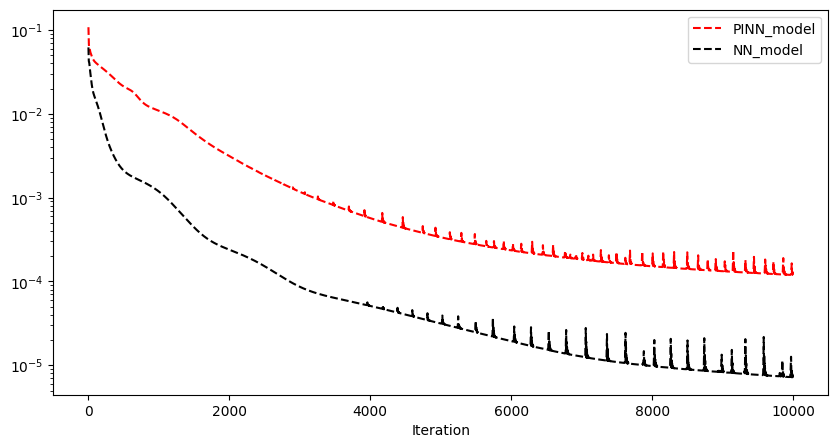

In [ ]:
import os   
wk_dir =  os.path.abspath('')

import torch
import torch.nn as nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
%matplotlib inline

def exact_solution(x, t):
    return torch.exp(-(x-x0)**2 / (2 * t)) / (torch.sqrt(2 * torch.pi * t))


class Sin(nn.Module):
    def forward(self, input: torch.Tensor, f=1.) -> torch.Tensor:
        return torch.sin(f*input)




# Define the neural network architecture
class PINN(nn.Module):
    def __init__(self, pinn=False):
        super(PINN, self).__init__()

        self.pinn = pinn

        self.net = nn.Sequential(
            nn.Linear(2, 16),
            nn.Tanh(),
            nn.Linear(16, 16),
            nn.Tanh(),
            nn.Linear(16, 1)
        )

    def forward(self, x, t):
        x_t = torch.cat([x, t], axis=1) # Concatenate x and t
        return self.net(x_t)




# Define the loss function
def fokker_planck_loss(model, x, t):

    # define boundary points, for the boundary loss
    rshp = int(x.shape[0]**.5)

    # Autograd for computing gradients
    p = model(x, t)

    p_exact = exact_solution(x, t)

    if model.pinn:

        p_t = torch.autograd.grad(p, t, torch.ones_like(p), create_graph=True)[0]
        p_x = torch.autograd.grad(p, x, torch.ones_like(p), create_graph=True)[0]
        p_xx = torch.autograd.grad(p_x, x, torch.ones_like(p_x), create_graph=True)[0]

        # Physics loss
        p_loss = torch.mean((p_t - 0.5*p_xx)**2)

        # Initial condition loss
        ic_loss = torch.mean((p.reshape(rshp,rshp)[:, 0:5] - p_exact.reshape(rshp,rshp)[:, 0:5])**2)
        

        # Boundary condition loss
        # bc_loss = torch.mean((p.reshape(rshp,rshp)[[0,-1], :] - p_exact.reshape(rshp,rshp)[[0,-1], :])**2)

        loss = p_loss + ic_loss# + bc_loss

    else:
        # data loss
        d_loss = torch.mean((p - p_exact)**2)
        loss = d_loss

    return loss


# Training
def train(model, epochs, optimizer, x, t):
    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()

        loss = fokker_planck_loss(model, x, t)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if epoch % 1000 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')
    return losses



# define data domain
x0 = 0.
x_ub = 5 # X upper bound
x_lb = -5 # X lower bound
nx = 100 # number of points in X

t0 = 0.1 # initial time
t1 = 0.50 # end of train time
t2 = 1.00 # end of test time
nt = 100 # number of points in T

n_epochs = 10000

# make training data: T in [t0, t1] and X in [x_lb, x_ub]
x_train = torch.Tensor(np.linspace(x_lb, x_ub, nx).reshape(-1, 1))
t_train = torch.Tensor(np.linspace(t0, t1, nt).reshape(-1, 1))

x_train, t_train = torch.meshgrid(x_train.squeeze(), t_train.squeeze())
x_train = x_train.reshape(-1, 1).requires_grad_(True).to(device)
t_train = t_train.reshape(-1, 1).requires_grad_(True).to(device)


fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# train the NN and PINN models
is_pinn = [True, False]
for pinn in is_pinn:

    if pinn:
        model_name = 'PINN_model'
        color = 'red'
    else:
        model_name = 'NN_model'
        color = 'black'

    # Initialize the model, optimizer, and training data
    model = PINN(pinn=pinn).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Train the model
    losses = train(model, epochs=n_epochs, optimizer=optimizer, x=x_train, t=t_train)

    # Plot the loss
    ax.plot(losses, label=model_name, color=color, linestyle='--')

    torch.save(model.state_dict(), f'{wk_dir}/{model_name}.pt')

plt.legend()
plt.yscale('log')
plt.xlabel('Iteration')
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import HTML
%matplotlib notebook

%matplotlib notebook
nt = int((t2-t0)/(t1-t0))*100

# make testing data: T in [t0, t2] and X in [x_lb, x_ub]
x_test = torch.Tensor(np.linspace(x_lb, x_ub, nx).reshape(-1, 1))
t_test = torch.Tensor(np.linspace(t0, t2, nt).reshape(-1, 1))

x_test, t_test = torch.meshgrid(x_test.squeeze(), t_test.squeeze())
x_test = x_test.reshape(-1, 1).to(device)
t_test = t_test.reshape(-1, 1).to(device)

# test the NN and PINN models
for pinn in [True, False]:

    if pinn:
        model_name = 'PINN_model'

    else:
        model_name = 'NN_model'

    # load the model from file
    model = PINN(pinn=pinn).to(device)
    model.load_state_dict(torch.load(f'{wk_dir}/{model_name}.pt'))

    model.eval()

    x_t = x_test.reshape(nx,nt)[:, 0].detach().cpu().numpy()

    p_true = exact_solution(x_test, t_test)
    p = model(x_test,t_test)
    pdiff = abs(p - p_true)

    p_true = p_true.reshape(nx,nt).detach().cpu().numpy()
    p = p.reshape(nx,nt).detach().cpu().numpy()
    pdiff = pdiff.reshape(nx,nt).detach().cpu().numpy()

    np.save(f'{wk_dir}/{model_name}_pdiff.npy', pdiff)


    fig = plt.figure()
    ax = fig.add_subplot(111)
    line1, = ax.plot(x_t, p[:,0], label='predicted')
    line2, = ax.plot(x_t, p_true[:,0], label='true')
    # line3, = ax.plot(x_t, pdiff[:,0], label='|diff|')
    plt.legend()
    # ax.set_xlim(-3,3)
    # ax.set_ylim(0,Z.max())

    losses = []

    def animate(i):
        line1.set_ydata(p[:,i])
        line2.set_ydata(p_true[:,i])
        # line3.set_ydata(pdiff[:,i])

        fontdict={"color": "black"}
        text = f'{model_name} | Time = {i*(t2-t0)/nt+t0:.2f}s | Loss = {np.mean(pdiff[:,i]):.2e}'


        ax.set_title(text, fontdict=fontdict)


    anim = FuncAnimation(fig, animate, np.arange(0, nt), interval=50, blit=True)
    anim.save(f'{wk_dir}/{model_name}.gif', writer='imagemagick', fps=30)

    # HTML(anim.to_jshtml())

<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


<IPython.core.display.Javascript object>

MovieWriter imagemagick unavailable; using Pillow instead.


Text(0.25, 0.3853199988603592, '$p_{nn}(x, t_{train})$')

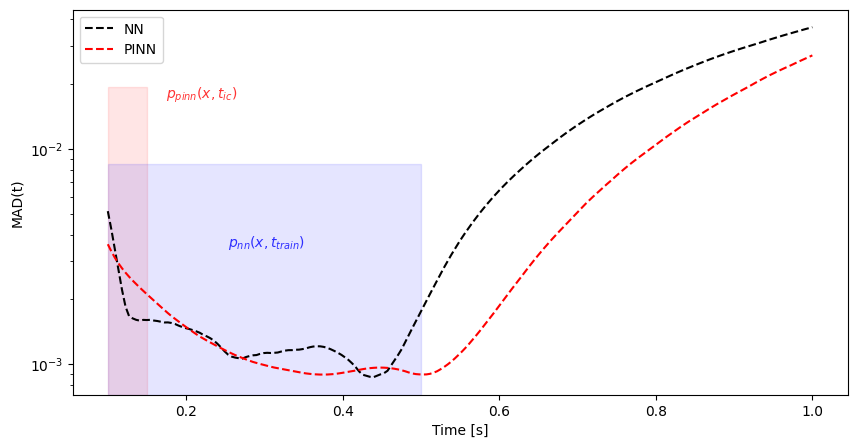

In [ ]:

%matplotlib inline
nn_pdiff = np.load(f'{wk_dir}/NN_model_pdiff.npy')
pinn_pdiff = np.load(f'{wk_dir}/PINN_model_pdiff.npy')


t_plot = np.linspace(t0, t2, nt)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()
plt.plot(t_plot, nn_pdiff.mean(axis=0), label='NN', color='black', linestyle='--')
plt.plot(t_plot, pinn_pdiff.mean(axis=0), label='PINN', color='red', linestyle='--')
plt.yscale('log')
plt.xlabel('Time [s]')
plt.ylabel('MAD(t)')
# plt.title(f'dt: {t1/nt:.2f}')
plt.axvspan(t0, t0+5/100, alpha=0.1, color='red', ymax=0.8)
plt.axvspan(t0, t1, alpha=0.1, color='blue', ymax=0.6)
plt.legend()


text_y = 0.8*(1-max(nn_pdiff.mean(axis=0).max(), pinn_pdiff.mean(axis=0).max()))
ax.text((t1)/3, text_y, "$p_{pinn}(x, t_{ic})$", ha='center', transform=ax.transAxes, color='red', alpha=.8)

text_y = 0.4*(1-max(nn_pdiff.mean(axis=0).max(), pinn_pdiff.mean(axis=0).max()))
ax.text((t1)/2, text_y, "$p_{nn}(x, t_{train})$", ha='center', transform=ax.transAxes, color='blue', alpha=.8)

